[참고]

https://www.youtube.com/watch?v=a4Yfz2FxXiY 

https://huggingface.co/blog/annotated-diffusion


In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
import math
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np

## Preparing the dataset

  0%|          | 0/330960 [00:00<?, ?it/s]

Extracting stanford_cars/car_devkit.tgz to stanford_cars


  0%|          | 0/979269282 [00:00<?, ?it/s]

Extracting stanford_cars/cars_train.tgz to stanford_cars


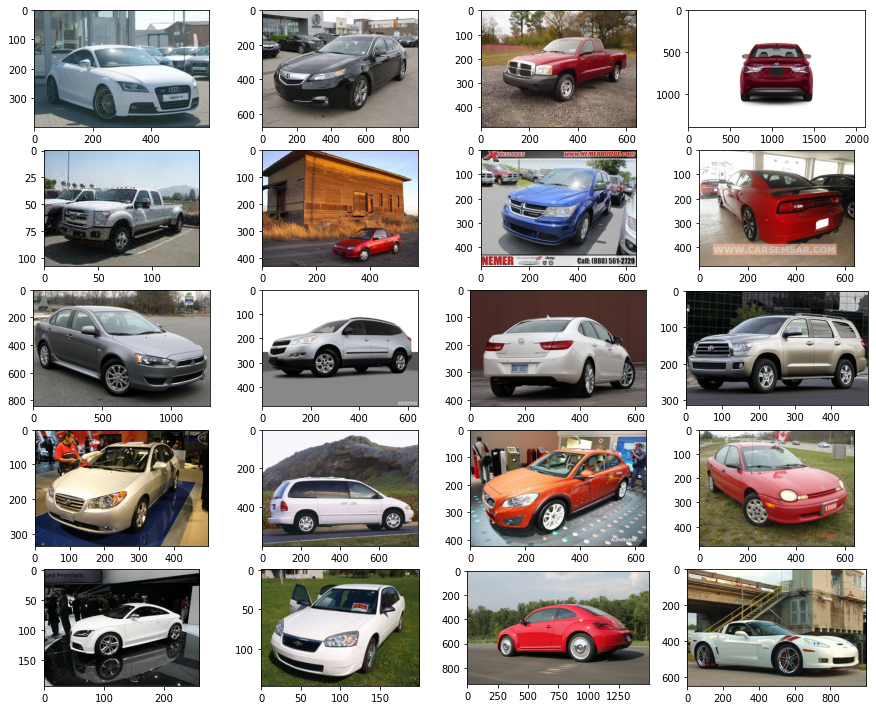

In [2]:
def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15)) 
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])

data = torchvision.datasets.StanfordCars(root=".", download=True)
show_images(data)

# Diffusion Model

## Forward Process

Forward Process

:  data $x_0$으로부터 noise를 더해가면서 최종 nosie $x_T$형태로 가는 과정

torch.gather(dim=x, indexTensor)

: input tensor의 타겟 dimension으로부터  indexTensor의 index에 해당하는 원소를 추출

torch.comprod(input,dim)

: input Tensor가 [$x_1$  $\cdots$ $x_i$]로 이루어져있을 때, output Tensor의 elements는 다음을 만족

$y_i = x_1 \times x_2 \times \cdots \times x_i$

F.pad(input,pad,mode='constant',value=None)

: pad는 2n개의 원소로 이루어져 있고 pad에 적힌 element만큼 padding

In [3]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [4]:
from os import device_encoding
def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it

    x_t(x_0, epsilon) = sqrt(alpha_cumprod_t)*x_0 + sqrt(1-alpha_cumpord_t)*epsilon
    epsilon ~ N(0,I)

    """
    noise = torch.randn_like(x_0).to(device)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape).to(device)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    ).to(device)

    return sqrt_alphas_cumprod_t*x_0.to(device) + sqrt_one_minus_alphas_cumprod_t*noise, noise


In [5]:
'''
beta_{T} : Variance Schedule
alpha_{t} = 1 - beta_{t}
alpha_comprod_{t} = alpha_1 x ... x alpha_{t}
q(x_t|x_0) = N(x_t; sqrt(alpha_comprod_{t})x_0,(1-alpha_comprod_{t})I)
sigma_{t}^2 = beta_cumprod = (1-alpha_comprod_{t-1})*beta_{t} / (1-alpha_comprod_{t})
'''
# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T) # 300
# Pre-calculate different terms for closed form
alphas = 1. - betas
# alpha_comprod_{t}
alphas_cumprod = torch.cumprod(alphas, axis=0)  # 300
# alpha_comprod_{t-1}
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)  # 300
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

Forward Process test

In [6]:
IMG_SIZE = 64
BATCH_SIZE = 128

In [7]:
def load_transformed_dataset():
    # transformers
    data_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),  # Horizontally flip
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ])

    train = torchvision.datasets.StanfordCars(root=".", download=True, 
                                         transform=data_transform)

    test = torchvision.datasets.StanfordCars(root=".", download=True, 
                                         transform=data_transform, split='test')
    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image):
    # load할 때와 반대 순서
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.), # to convert to image
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

In [8]:
data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Using downloaded and verified file: stanford_cars/car_devkit.tgz
Extracting stanford_cars/car_devkit.tgz to stanford_cars


  0%|          | 0/977350468 [00:00<?, ?it/s]

Extracting stanford_cars/cars_test.tgz to stanford_cars


  0%|          | 0/185758 [00:00<?, ?it/s]

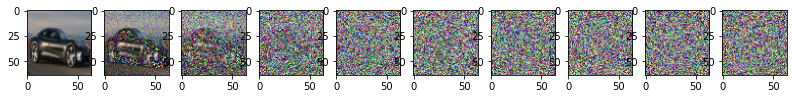

In [9]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    image, noise = forward_diffusion_sample(image, t)
    show_tensor_image(image)

## Backward Process

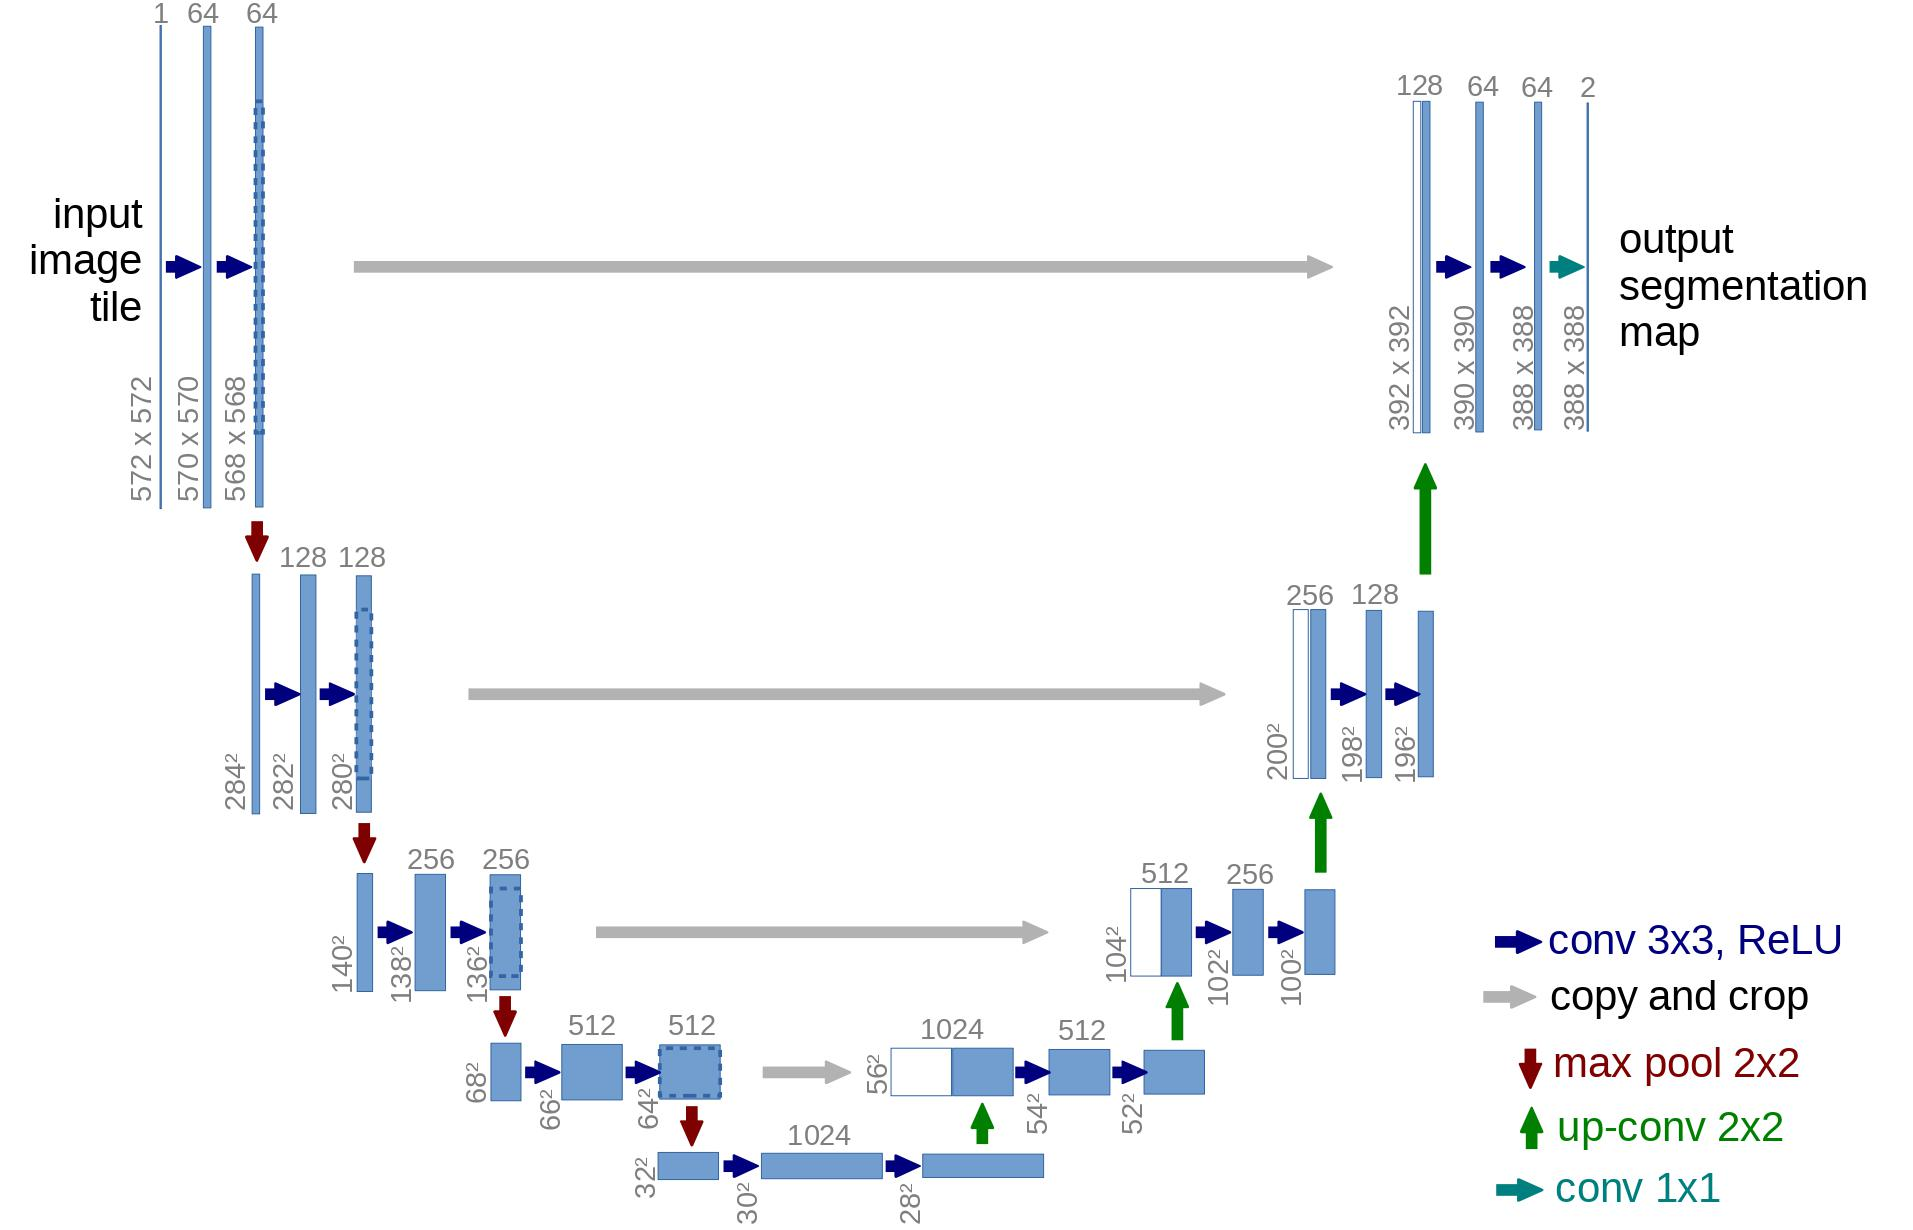

In [10]:
class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_channel)
        if up :
            self.conv1 = nn.Conv2d(2*in_channel, out_channel, 3, padding=1)
            # up sampling
            self.transform = nn.ConvTranspose2d(out_channel,out_channel, 4, 2, 1)
        else :
            self.conv1 = nn.Conv2d(in_channel, out_channel, 3, padding=1)
            # down samlping
            self.transform =  nn.Conv2d(out_channel, out_channel, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_channel, out_channel, 3, padding=1)
        self.bn = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()

    def forward(self, x, t, ):
        h = self.bn(self.relu(self.conv1(x)))
        # Time Embedding
        time_emb = self.relu(self.time_mlp(t))
        # Add Time_emb
        time_emb = time_emb[(... , ) + (None, )*2]
        h = h + time_emb  # extend dimensions
        h = self.bn(self.relu(self.conv2(h)))
        h = self.transform(h)
        return h


class TimeEmbeddings(nn.Module):
    """
    신경망이 어떤 특정 시간 단계(노이즈 레벨)에서 
    작동하는지를 일괄적으로 모든 이미지에 대해 알게 만든다.
    """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

        return embeddings


class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = [64, 128, 256, 512, 1024]
        up_channels = [1024, 512, 256, 128, 64]
        out_dim = 1 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                TimeEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([ConvBlock(down_channels[i], down_channels[i+1], time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([ConvBlock(up_channels[i], up_channels[i+1], time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        # U net
        residual_inputs = []

        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        
        return self.output(x)

In [11]:
model = Unet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62433123


Unet(
  (time_mlp): Sequential(
    (0): TimeEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): ConvBlock(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): ConvBlock(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(256, 256, kernel_si

**Further improvements that can be implemented:**
- Residual connections
- Different activation functions like SiLU, GWLU, ...
- BatchNormalization 
- GroupNormalization
- Attention
- ...

## Loss Function

In [12]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    
    return F.l1_loss(noise, noise_pred)

## Sampling

@torch.no_grad()

pytorch는 기본적으로 gradient 계산을 하지만, 불필요시 메모리를 절약하기 위해 사용

In [13]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()      

# Training

Epoch 0 | step 000 Loss: 0.810389518737793 


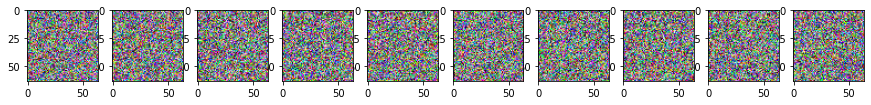

Epoch 5 | step 000 Loss: 0.15877054631710052 


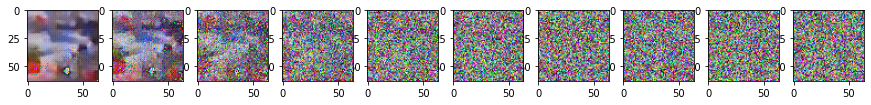

Epoch 10 | step 000 Loss: 0.15275299549102783 


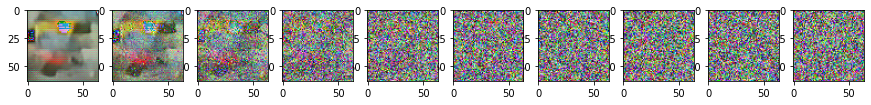

Epoch 15 | step 000 Loss: 0.15084335207939148 


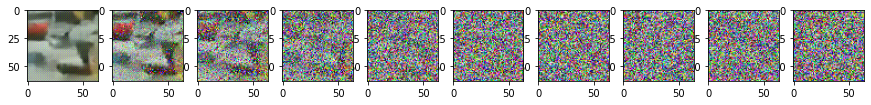

In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()